In [1]:
import os
import pickle
#import rpy2.robjects as robjects
import torch
from torch.autograd import Variable
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import scipy.sparse as sp
from torchvision import transforms as tfs
from torch_geometric.data import HeteroData
import torch_geometric.transforms as T
from torch_geometric.nn import HGTConv, Linear
#from torch_geometric.loader import HGTLoader
from torch.cuda.amp import autocast
from torch_geometric.utils import negative_sampling
from sklearn.metrics import roc_auc_score
#from torchsummary import summary
import random
from sklearn.metrics import roc_curve, auc, f1_score, precision_recall_curve, average_precision_score
from torch.utils.data import WeightedRandomSampler
import math
# from einops import rearrange, reduce
# from einops.layers.torch import Rearrange
from torch.nn.parameter import Parameter

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(2022)

In [2]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3,venn2
from sklearn.metrics import roc_curve, auc, f1_score, precision_recall_curve, average_precision_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

In [4]:
# with open('/lustre06/project/6050659/liupei89/Testcell/newNetData/pos_neg/newdataCombine00_newall.pkl','rb') as f:  # Python 3: open(..., 'rb')
#         train_data,val_data,test_data,m,g = pickle.load(f)

# train_data ['miRNA'].sim = train_data ['miRNA'].mm + train_data ['miRNA'].x
# val_data ['miRNA'].sim = train_data ['miRNA'].mm + train_data ['miRNA'].x
# test_data ['miRNA'].sim = train_data ['miRNA'].mm + train_data ['miRNA'].x
# train_data ['gene'].sim = train_data ['gene'].gg + train_data ['gene'].x
# val_data ['gene'].sim = train_data ['gene'].gg + train_data ['gene'].x
# test_data ['gene'].sim = train_data ['gene'].gg + train_data ['gene'].x
# nodetypes=train_data.node_types
# metadata=train_data.metadata()

In [3]:
with open('./results/hnuResults/results/HGTlinkloader_resultgpu.pkl','rb') as f:  # Python 3: open(..., 'rb')
        tp_hgt,fp_hgt,tn_hgt,fn_hgt,rel_hgt,pre_hgt = pickle.load(f)

In [21]:
with open('./results/hnuResults/results/miRGraphstepbystep_resultgpu.pkl','rb') as f:  # Python 3: open(..., 'rb')
        tp_her,fp_her,tn_her,fn_her,rel_her,pre_her = pickle.load(f)

In [4]:
with open('./results/hnuResults/results/miRGraphendtoend_result.pkl','rb') as f:  # Python 3: open(..., 'rb')
        tp_her,fp_her,tn_her,fn_her,rel_her,pre_her = pickle.load(f)

In [5]:
with open('./results/hnuResults/results/TransCNN_resultgpu.pkl','rb') as f:  # Python 3: open(..., 'rb')
        tp_cnn,fp_cnn,tn_cnn,fn_cnn,rel_cnn,pre_cnn = pickle.load(f)

In [6]:
tp_hgt.size(0)/(fn_hgt.size(0)+tp_hgt.size(0))

0.7749018152580636

In [7]:
tp_her.size(0)/(fn_her.size(0)+tp_her.size(0))

0.820546123635464

In [8]:
tp_cnn.size(0)/(fn_cnn.size(0)+tp_cnn.size(0))

0.8397501314283947

In [9]:
tp_hgt.size(0)/(fp_hgt.size(0)+tp_hgt.size(0))

0.7422173513817719

In [10]:
tp_her.size(0)/(fp_her.size(0)+tp_her.size(0))

0.7892795526206199

In [11]:
tp_cnn.size(0)/(fp_cnn.size(0)+tp_cnn.size(0))

0.8142184642139666

In [12]:
(tp_hgt.size(0)+tn_hgt.size(0))/(fp_hgt.size(0)+tp_hgt.size(0)+fn_hgt.size(0)+tn_hgt.size(0))

0.8386161908897214

In [13]:
(tp_her.size(0)+tn_her.size(0))/(fp_her.size(0)+tp_her.size(0)+fn_her.size(0)+tn_her.size(0))

0.8698690309095132

In [14]:
(tp_cnn.size(0)+tn_cnn.size(0))/(fp_cnn.size(0)+tp_cnn.size(0)+fn_cnn.size(0)+tn_cnn.size(0))

0.8851066837656896

In [15]:
tp_hgt

tensor([    7,     9,    11,  ..., 99020, 99024, 99025])

In [16]:
tp_her

tensor([    0,     1,     2,  ..., 32333, 32335, 32336])

In [17]:
tp_cnn

tensor([    9,    11,    15,  ..., 99020, 99024, 99025])

In [18]:
a=set(tp_cnn.numpy())
b=set(tp_her.numpy())
c=torch.tensor(list(a&b))
tp=c
print(tp.size())#1419 1488

torch.Size([7334])


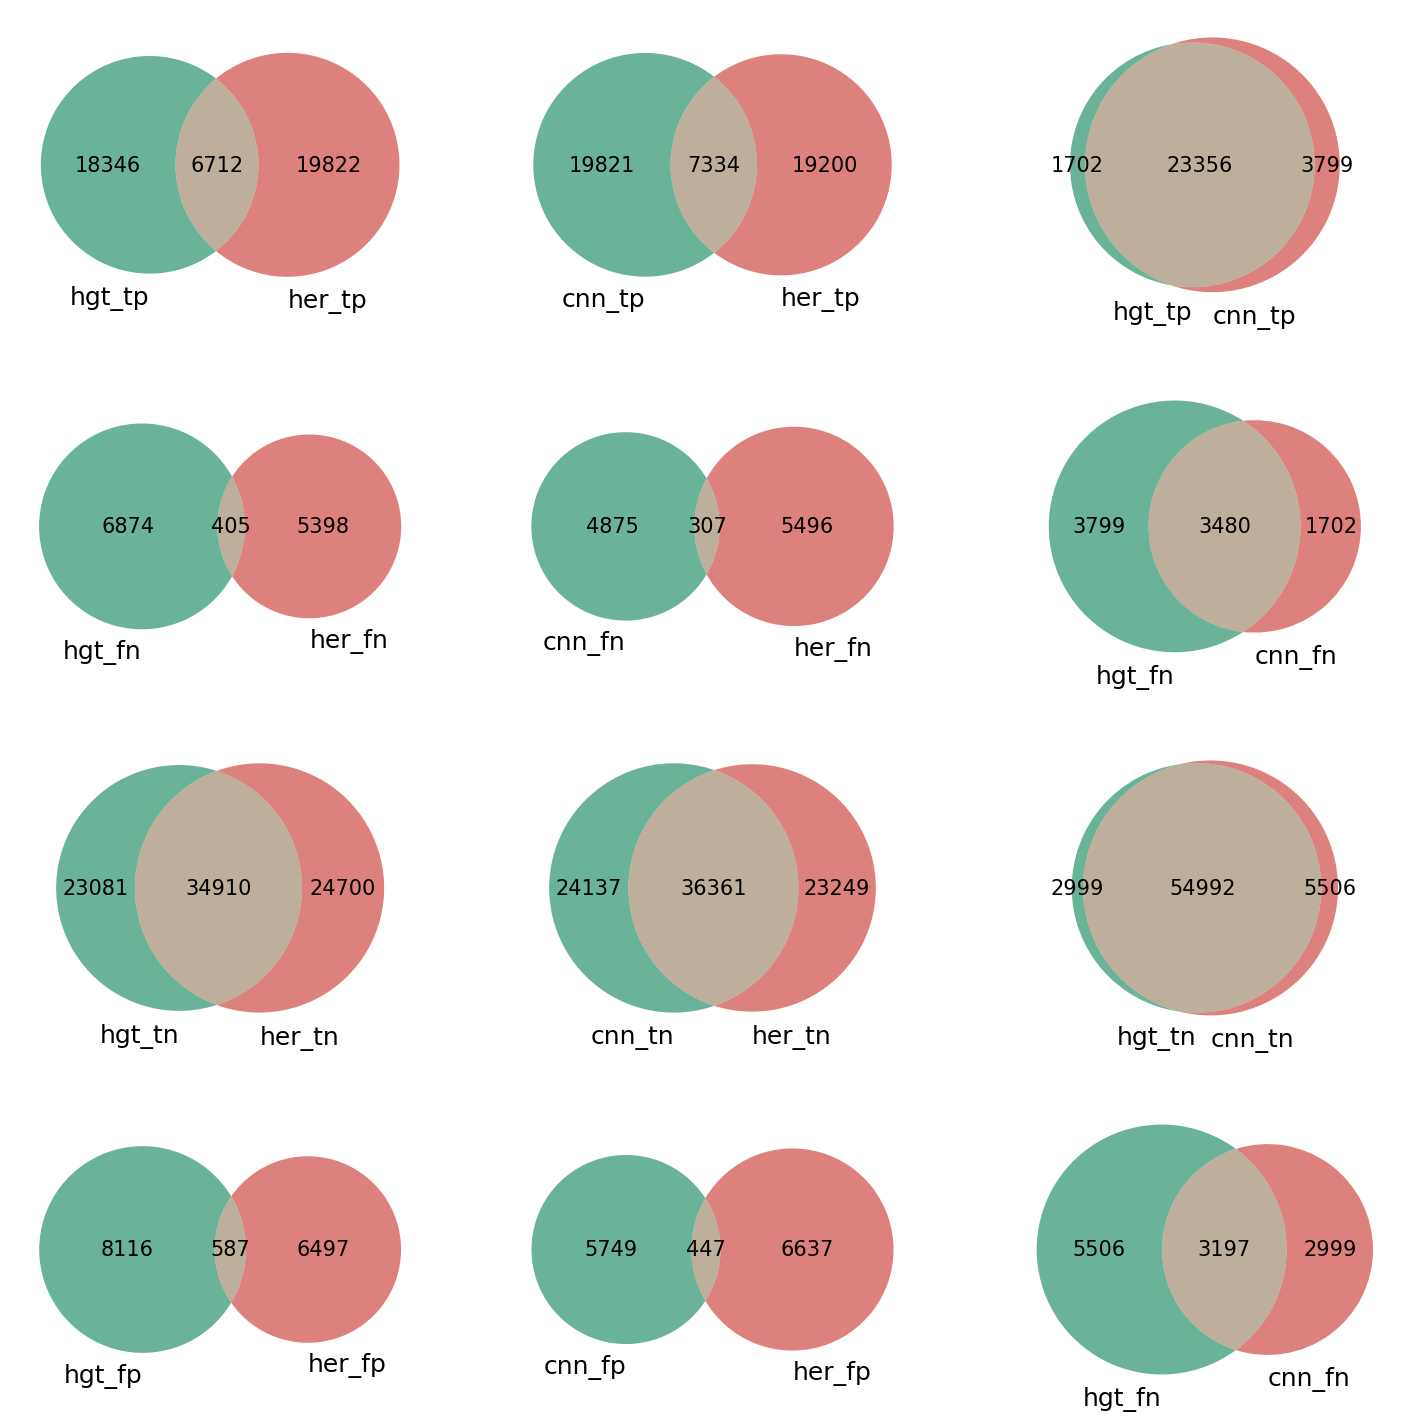

In [19]:
fig,axs=plt.subplots(4,3, figsize=(12,12),dpi=150)
# g=venn2(subsets = [set(tp_hgt.numpy()),set(tp_her.numpy())],
#         set_labels=('hgt_tp','her_tp'),
#         set_colors=("#098154","#c72e29"),
#         alpha=0.6,
#         normalize_to=1.0,
#         ax=axs[0,0],#该参数指定
#        )
g=venn2(subsets = [set(tp_hgt.numpy()),set(tp_her.numpy())],
        set_labels=('hgt_tp','her_tp'),
        set_colors=("#098154","#c72e29"),
        alpha=0.6,
        normalize_to=1.0,
        ax=axs[0,0],#该参数指定
       )
g=venn2(subsets = [set(tp_cnn.numpy()),set(tp_her.numpy())],
        set_labels=('cnn_tp','her_tp'),
        set_colors=("#098154","#c72e29"),
        alpha=0.6,
        normalize_to=1.0,
        ax=axs[0,1],
       )
g=venn2(subsets = [set(tp_hgt.numpy()),set(tp_cnn.numpy())],
        set_labels=('hgt_tp','cnn_tp'),
        set_colors=("#098154","#c72e29"),
        alpha=0.6,
        normalize_to=1.0,
        ax=axs[0,2],
       )
g=venn2(subsets = [set(fn_hgt.numpy()),set(fn_her.numpy())],
        set_labels=('hgt_fn','her_fn'),
        set_colors=("#098154","#c72e29"),
        alpha=0.6,
        normalize_to=1.0,
        ax=axs[1,0],#该参数指定
       )
g=venn2(subsets = [set(fn_cnn.numpy()),set(fn_her.numpy())],
        set_labels=('cnn_fn','her_fn'),
        set_colors=("#098154","#c72e29"),
        alpha=0.6,
        normalize_to=1.0,
        ax=axs[1,1],
       )
g=venn2(subsets = [set(fn_hgt.numpy()),set(fn_cnn.numpy())],
        set_labels=('hgt_fn','cnn_fn'),
        set_colors=("#098154","#c72e29"),
        alpha=0.6,
        normalize_to=1.0,
        ax=axs[1,2],
       )
g=venn2(subsets = [set(tn_hgt.numpy()),set(tn_her.numpy())],
        set_labels=('hgt_tn','her_tn'),
        set_colors=("#098154","#c72e29"),
        alpha=0.6,
        normalize_to=1.0,
        ax=axs[2,0],#该参数指定
       )
g=venn2(subsets = [set(tn_cnn.numpy()),set(tn_her.numpy())],
        set_labels=('cnn_tn','her_tn'),
        set_colors=("#098154","#c72e29"),
        alpha=0.6,
        normalize_to=1.0,
        ax=axs[2,1],
       )
g=venn2(subsets = [set(tn_hgt.numpy()),set(tn_cnn.numpy())],
        set_labels=('hgt_tn','cnn_tn'),
        set_colors=("#098154","#c72e29"),
        alpha=0.6,
        normalize_to=1.0,
        ax=axs[2,2],
       )
g=venn2(subsets = [set(fp_hgt.numpy()),set(fp_her.numpy())],
        set_labels=('hgt_fp','her_fp'),
        set_colors=("#098154","#c72e29"),
        alpha=0.6,
        normalize_to=1.0,
        ax=axs[3,0],#该参数指定
       )
g=venn2(subsets = [set(fp_cnn.numpy()),set(fp_her.numpy())],
        set_labels=('cnn_fp','her_fp'),
        set_colors=("#098154","#c72e29"),
        alpha=0.6,
        normalize_to=1.0,
        ax=axs[3,1],
       )
g=venn2(subsets = [set(fp_hgt.numpy()),set(fp_cnn.numpy())],
        set_labels=('hgt_fn','cnn_fn'),
        set_colors=("#098154","#c72e29"),
        alpha=0.6,
        normalize_to=1.0,
        ax=axs[3,2],
       )
plt.savefig('./testvenn2_new_1.jpg')
plt.show()

In [ ]:
fig,axs=plt.subplots(2,2, figsize=(12,10),dpi=200)
#my_dpi=100
#plt.figure(figsize=(800/my_dpi, 600/my_dpi), dpi=my_dpi)#控制图尺寸的同时，使图高分辨率（高清）显示
g=venn3(
    subsets = [set(tp_hgt.numpy()),set(tp_her.numpy()),set(tp_cnn.numpy())],
    set_labels=('HGT_TP','MiRGraph_TP','TransCNN_TP'),
    set_colors=('r','g','b'),
    ax=axs[0,0],
)
for text in g.set_labels:
    text.set_fontsize(14);
    #text.set_fontweight("bold")
for text in g.subset_labels:
    text.set_fontsize(12)
    text.set_fontweight("bold")
g=venn3(
    subsets = [set(fn_hgt.numpy()),set(fn_her.numpy()),set(fn_cnn.numpy())],
    set_labels=('HGT_FN','MiRGraph_FN','TransCNN_FN'),
    set_colors=('r','g','b'),
    ax=axs[0,1],
)
for text in g.set_labels:
    text.set_fontsize(14);
    #text.set_fontweight("bold")
for text in g.subset_labels:
    text.set_fontsize(12)
    text.set_fontweight("bold")
g=venn3(
    subsets = [set(tn_hgt.numpy()),set(tn_her.numpy()),set(tn_cnn.numpy())],
    set_labels=('HGT_TN','MiRGraph_TN','TransCNN_TN'),
    set_colors=('r','g','b'),
    ax=axs[1,0],
)
for text in g.set_labels:
    text.set_fontsize(14);
    #text.set_fontweight("bold")
for text in g.subset_labels:
    text.set_fontsize(12)
    text.set_fontweight("bold")
g=venn3(
    subsets = [set(fp_hgt.numpy()),set(fp_her.numpy()),set(fp_cnn.numpy())],
    set_labels=('HGT_FP','MiRGraph_FP','TransCNN_FP'),
    set_colors=('r','g','b'),
    ax=axs[1,1],
)
for text in g.set_labels:
    text.set_fontsize(14);
    #text.set_fontweight("bold")
for text in g.subset_labels:
    text.set_fontsize(12)
    text.set_fontweight("bold")
#然后就可以如同venn2中那样个性化设置了
subplot_labels = ['(a)', '(b)', '(c)', '(d)']
#subplot_labels = ['a', 'b', 'c', 'd']
for ax, label in zip(axs.flat, subplot_labels):
    # 在子图左上角添加编号
    #ax.text(0.02, 0.98, label, transform=ax.transAxes, fontsize=10, fontweight='bold', va='top')
        # x=0.5 表示横向中央, y=-0.2 表示稍微低于子图底部, 相对于子图的坐标系
    ax.text(0.5, -0.1, label, transform=ax.transAxes, fontsize=14, fontweight='bold', va='top', ha='center')

#plt.savefig('./testvenn3_new_111.jpg')
plt.savefig('./results/hnuResults/results/testvenn3_new.pdf', bbox_inches='tight')
plt.show()

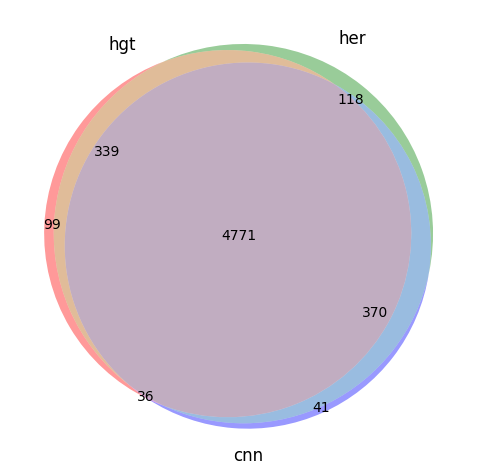

In [33]:
my_dpi=100
plt.figure(figsize=(800/my_dpi, 600/my_dpi), dpi=my_dpi)#控制图尺寸的同时，使图高分辨率（高清）显示
venn3(
    subsets = [set(tn_hgt.numpy()),set(tn_her.numpy()),set(tn_cnn.numpy())],
    set_labels=('hgt','her','cnn'),
    set_colors=('r','g','b'))

NameError: name 'ax' is not defined

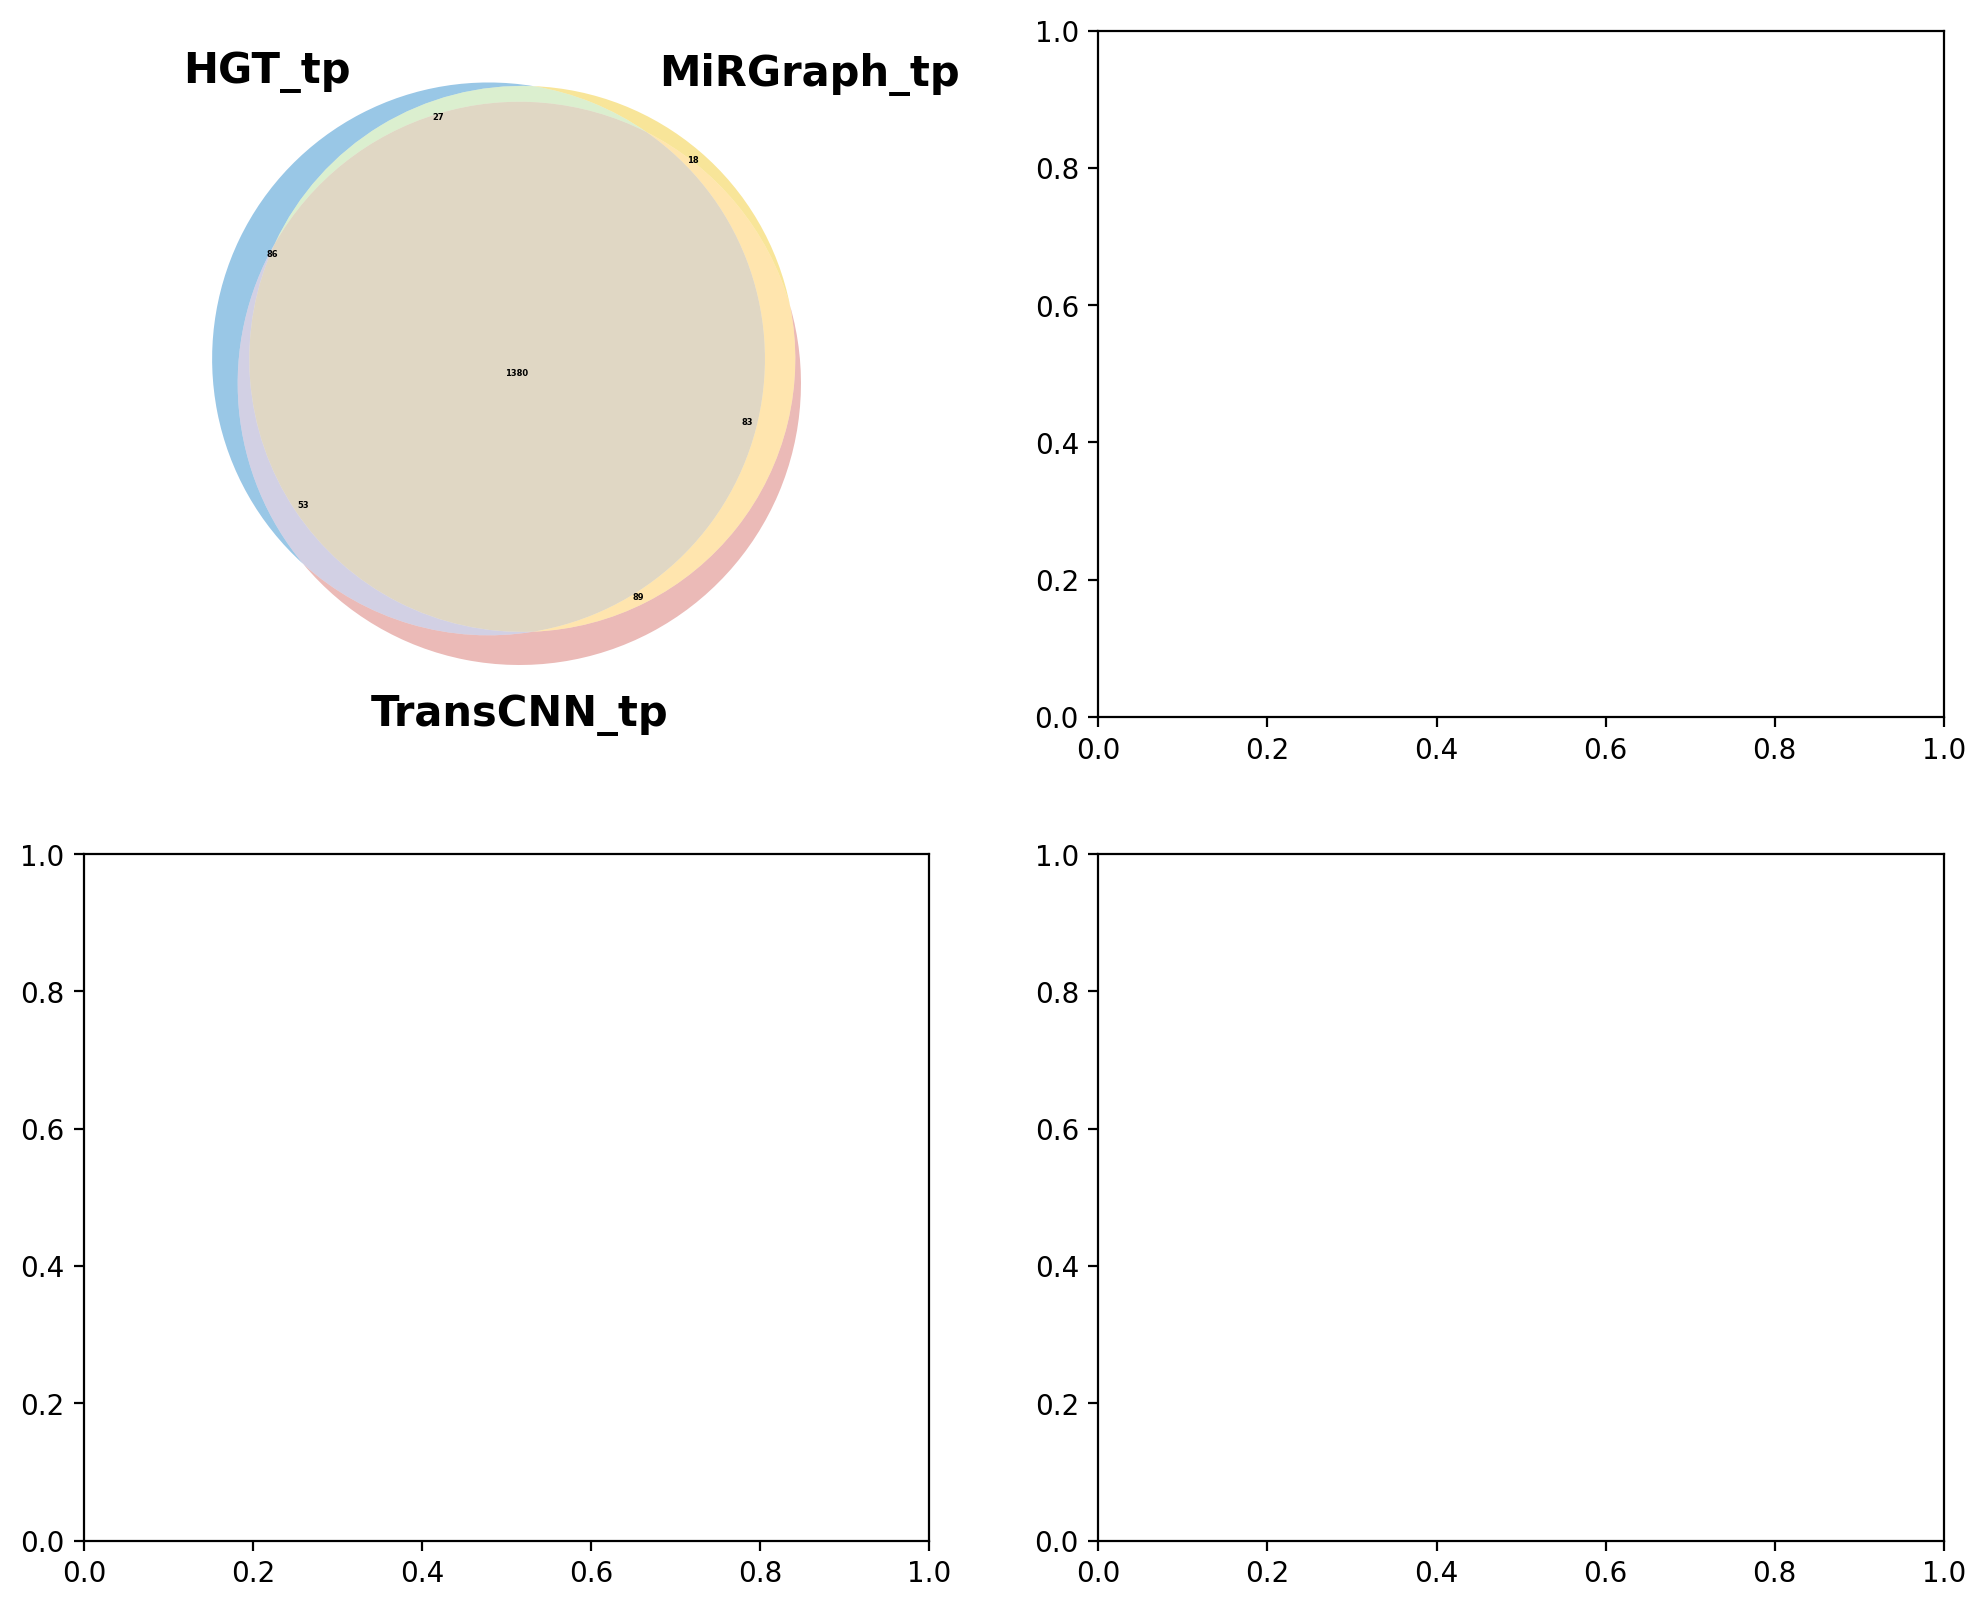

In [23]:
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
import matplotlib.pyplot as plt
fig,axs=plt.subplots(2,2, figsize=(12,10),dpi=200)
g=venn3(
    subsets = [set(tp_hgt.numpy()),set(tp_her.numpy()),set(tp_cnn.numpy())],
    set_labels=('HGT_tp','MiRGraph_tp','TransCNN_tp'),
    set_colors=('#0073C2FF','#EFC000FF',"#CD534CFF"),
    ax=axs[0,0],
)
for text in g.set_labels:
    text.set_fontsize(15);
    text.set_fontweight("bold")
for text in g.subset_labels:
    text.set_fontsize(3)
    text.set_fontweight("bold")
ax.text(.8,-.1,'\na',transform = ax.transAxes,
        ha='center', va='center',fontsize = 9,color='black')
g=venn3(
    subsets = [set(fn_hgt.numpy()),set(fn_her.numpy()),set(fn_cnn.numpy())],
    set_labels=('HGT_fn','MiRGraph_fn','TransCNN_fn'),
    set_colors=('#0073C2FF','#EFC000FF',"#CD534CFF"),
    ax=axs[0,1],
)
for text in g.set_labels:
    text.set_fontsize(15);
    text.set_fontweight("bold")
for text in g.subset_labels:
    text.set_fontsize(8)
    text.set_fontweight("bold")
ax.text(.8,-.1,'\nb',transform = ax.transAxes,
    ha='center', va='center',fontsize = 9,color='black')
g=venn3(
    subsets = [set(tn_hgt.numpy()),set(tn_her.numpy()),set(tn_cnn.numpy())],
    set_labels=('HGT_tn','MiRGraph_tn','TransCNN_tn'),
    set_colors=('#0073C2FF','#EFC000FF',"#CD534CFF"),
    ax=axs[1,0],
    
)
for text in g.set_labels:
    text.set_fontsize(10);
    text.set_fontweight("bold")
for text in g.subset_labels:
    text.set_fontsize(8)
    text.set_fontweight("bold")
ax.text(.8,-.1,'\nc',transform = ax.transAxes,
        ha='center', va='center',fontsize = 9,color='black')
g=venn3(
    subsets = [set(fp_hgt.numpy()),set(fp_her.numpy()),set(fp_cnn.numpy())],
    set_labels=('HGT_fp','MiRGraph_fp','TransCNN_fp'),
    set_colors=('#0073C2FF','#EFC000FF',"#CD534CFF"),
    ax=axs[1,1],
)
# 定制化设置
for text in g.set_labels:
    text.set_fontsize(10);
    text.set_fontweight("bold")
for text in g.subset_labels:
    text.set_fontsize(8)
    text.set_fontweight("bold")
ax.text(.8,-.1,'\nd',transform = ax.transAxes,
        ha='center', va='center',fontsize = 9,color='black')
# ax.text(.8,-.1,'\nVisualization by DataCharm',transform = ax.transAxes,
#         ha='center', va='center',fontsize = 9,color='black')
# plt.title("Example Of venn3() and venn3_circles()",fontweight="bold",fontsize=15,
#           pad=30,backgroundcolor="#868686FF",color="black",style="italic")
#plt.savefig('./testvenn3_new_1.jpg')
plt.show()

In [24]:
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Example Of venn3() and venn3_circles()')

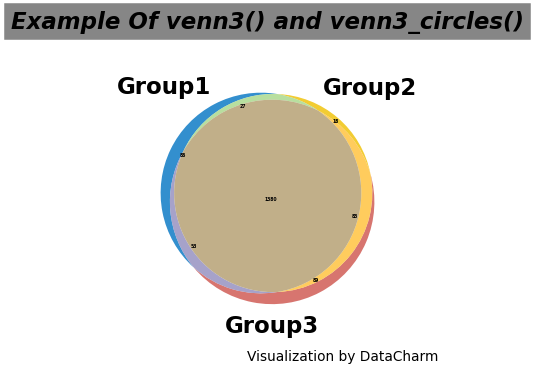

In [25]:
fig, ax = plt.subplots(figsize=(5,3),dpi=110)
vd3=venn3([set(tp_hgt.numpy()),set(tp_her.numpy()),set(tp_cnn.numpy())],
          set_labels=("Group1","Group2","Group3"),
          set_colors=('#0073C2FF','#EFC000FF',"#CD534CFF"), 
          alpha = 0.8,ax=ax)
#venn3_circles([set(tp_hgt.numpy()),set(tp_her.numpy()),set(tp_cnn.numpy())], linestyle="-", linewidth=2, color="black",ax=ax)
# 定制化设置
for text in vd3.set_labels:
    text.set_fontsize(15);
    text.set_fontweight("bold")
for text in vd3.subset_labels:
    text.set_fontsize(3)
    text.set_fontweight("bold")
ax.text(.8,-.1,'\nVisualization by DataCharm',transform = ax.transAxes,
        ha='center', va='center',fontsize = 9,color='black')
plt.title("Example Of venn3() and venn3_circles()",fontweight="bold",fontsize=15,
          pad=30,backgroundcolor="#868686FF",color="black",style="italic")

In [ ]:
# my_dpi=100
# plt.figure(figsize=(800/my_dpi, 600/my_dpi), dpi=my_dpi)#控制图尺寸的同时，使图高分辨率（高清）显示
# venn3(
#     subsets = [set([1,2,3,5,9]),set([1,2,4,6]),set([1,3,4,7])],
#     set_labels=('A','B','C'),
#     set_colors=('r','g','b')
# )
# plt.savefig('./test.jpg')
# plt.show()